#**Overview:**

In this notebook the BERT models are trained and evaluated. The results and weights of each model and experiment are saved to a file for future comparison. The highest performing model is then used for the final text embeddings that will be used in the multimodal model. finally the same model is then evaluated on it's own on the test data to serve as a benchmark.

#**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
import seaborn as sns
from tqdm import tqdm
from sklearn.utils import resample
from google.colab import drive
from transformers import BertForSequenceClassification, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch.optim import Adagrad

#**Data Preparation**

In [2]:
# load csv file from my google drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Dissertation/pneumonia_full.csv') # alt: pneumonia2 with two parts, or pneumonia_full with all of the data


#converting labels to non negative integers (0,1,2)
labels = [label for label in df['pneumonia']]
for i in range(len(labels)):
  if labels[i]==-1:
    labels[i]=2

df['pneumonia'] = [int(label) for label in labels]
df = df[df['pneumonia'] !=2]
df = df.reset_index(drop=True)
#use split column of dataframe for splitting the data
train = df[df['split']=='train']
val = df[df['split']=='validate']
test = df[df['split']=='test']

Mounted at /content/drive


In [3]:
train['pneumonia'].value_counts()[0]

24436

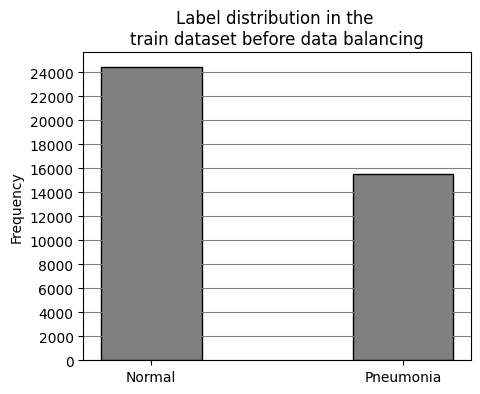

In [4]:
#frequency before balancing
plt.figure(figsize=(5,4))
plt.hist(train['pneumonia'], bins=[-0.5,0.5, 1.5], color = 'grey',edgecolor='black', align='mid',rwidth = 0.4)
plt.title('Label distribution in the \ntrain dataset before data balancing')
plt.ylabel('Frequency')
plt.grid(True, axis='y', color='grey')
plt.yticks([i for i in range(0,train['pneumonia'].value_counts()[0],2000)])
plt.xticks([0, 1], ['Normal', 'Pneumonia'])
plt.yticks()
plt.show()

In [5]:
#balancing the data using undersampling
def data_balancing(df,label,values): # df: dataframe, label: the label to be balanced
  n = min(df[label].value_counts())
  #split on label value (0 or 1)
  df_class0 = df[df[label] == values[0]]
  df_class1 = df[df[label] == values[1]]
  #use resample without replacement to randomly remove rows from majority (random state is set for reproducable)
  df_class0 = resample(df_class0, replace=False, n_samples=n,random_state = 69)
  df_class1 = resample(df_class1, replace=False, n_samples=n, random_state = 69)
  #join the two classes back to a single dataframe
  df_balanced = pd.concat([df_class0, df_class1], axis=0)
  #shuffle the rows and reset index
  df_balanced = df_balanced.sample(frac=1,random_state=69).reset_index(drop=True)

  return df_balanced


n1 = len(train)
# sample a small part of the dataset for the experiments
size = int(len(df)/10)
train = resample(train, replace=False, n_samples=size,random_state=69).reset_index(drop=True)
n2= len(train)

print(f"Training size war reduced from {n1} to {n2}")

#balanace the classes of the training data
train = data_balancing(train,'pneumonia',[0,1])

#reset index and randomise order for validation and test sets
val = val.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)



# check to see if classes are balanced
print(train['pneumonia'].value_counts())

Training size war reduced from 39916 to 4081
pneumonia
0    1629
1    1629
Name: count, dtype: int64


#**Model Loading and Data Encoding**

In [6]:
# load the model and the tokenizer
model_name_list = ['emilyalsentzer/Bio_ClinicalBERT','bert-base-uncased','dmis-lab/biobert-base-cased-v1.1','bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12']
model_name = model_name_list[0]
# filename = model_name
filename = model_name.split('/')[1] #Bio_ClinicalBERT, BioBERT, BlueBERT

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)


# encode the text to create object with input id's and the attention mask
train_texts=train['text'].tolist()
val_texts = val['text'].tolist()
test_texts = test['text'].tolist()

#encoding function
def bert_encoder(texts, tokenizer):
  encoding = tokenizer(
      texts,
      padding=True,
      truncation=True,
      max_length=512,
      return_tensors='pt'
  )
  return encoding

#encoding for the BERT model
encoding_train = bert_encoder(train_texts, tokenizer)
encoding_validate = bert_encoder(val_texts, tokenizer)
encoding_test = bert_encoder(test_texts, tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
sentence = train['text'][4]
print(sentence)

                                 FINAL REPORT
 EXAMINATION:  CHEST (PORTABLE AP)
 
 INDICATION:  ___ year old woman with acute delirium and hypotension  // signs
 of consolidation, pna
 
 TECHNIQUE:  Single frontal view of the chest
 
 COMPARISON:  Chest radiograph ___
 
 FINDINGS: 
 
 Patient has history of CABG with median sternotomy wires and mediastinal clips
 seen.  Chronic elevation of the right hemidiaphragm is unchanged.  Low lung
 volumes bilaterally.  Cardio mediastinal silhouette is unchanged.  Mild
 pulmonary vascular congestion bilaterally unchanged or minimally improved. 
 There is no pneumothorax or pleural effusion.   No evidence of pneumonia.
 
 IMPRESSION: 
 
 No evidence of pneumonia.  Bilateral mild pulmonary vascular congestion
 unchanged or minimally improved.



In [8]:
tkn = tokenizer.convert_ids_to_tokens(encoding_train['input_ids'][4])
n = len(tkn)
for i in range(0,n,15):
  if tkn[i] != '[PAD]' :
    print(tkn[i:i+15])

['[CLS]', 'final', 'report', 'examination', ':', 'chest', '(', 'portable', 'a', '##p', ')', 'indication', ':', '_', '_']
['_', 'year', 'old', 'woman', 'with', 'acute', 'del', '##iri', '##um', 'and', 'h', '##y', '##pot', '##ens', '##ion']
['/', '/', 'signs', 'of', 'consolidation', ',', 'p', '##na', 'technique', ':', 'single', 'frontal', 'view', 'of', 'the']
['chest', 'comparison', ':', 'chest', 'radio', '##graph', '_', '_', '_', 'findings', ':', 'patient', 'has', 'history', 'of']
['cab', '##g', 'with', 'median', 'stern', '##oto', '##my', 'wires', 'and', 'media', '##st', '##inal', 'clips', 'seen', '.']
['chronic', 'elevation', 'of', 'the', 'right', 'hem', '##id', '##ia', '##ph', '##rag', '##m', 'is', 'unchanged', '.', 'low']
['lung', 'volumes', 'bilateral', '##ly', '.', 'card', '##io', 'media', '##st', '##inal', 'silhouette', 'is', 'unchanged', '.', 'mild']
['pulmonary', 'vascular', 'congestion', 'bilateral', '##ly', 'unchanged', 'or', 'minimal', '##ly', 'improved', '.', 'there', 'is', '

In [9]:
#creating a dataset class for training using pytorch
class PneumoniaDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).long().clone().detach()
        # item['labels'] = self.labels[idx].long().clone().detach()
        return item


# Convert labels to tensors
labels_train = torch.tensor(train['pneumonia'], dtype=torch.long)
labels_val = torch.tensor(val['pneumonia'], dtype=torch.long)
labels_test = torch.tensor(test['pneumonia'], dtype=torch.long)


pneumonia_train = PneumoniaDataset(encoding_train, labels_train)
pneumonia_val =  PneumoniaDataset(encoding_validate, labels_val)
pneumonia_test = PneumoniaDataset(encoding_test, labels_test)

# Set up the device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Move the model to the device
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

#**Model Training**

setting up the parameters and creating the data loaders:

In [10]:

hp = {
    'learning_rate': 5e-5,
    'weight_decay':1e-2,
    'gamma' : 0.2,
    'batch_size': 16,
    'epochs': 5,
    'optimiser':'AdamW',
}
# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Optimizer

optimiser = torch.optim.AdamW(model.parameters(), lr=hp['learning_rate'],weight_decay=hp['weight_decay'])
# optimiser = torch.optim.SGD(model.parameters(), lr=hp['learning_rate'],weight_decay=hp['weight_decay'], momentum=0.9) #SGD optimiser

# Scheduler
scheduler = StepLR(optimiser, step_size=1, gamma=hp['gamma'])

# create the data loaders
batches = hp['batch_size']
train_loader = DataLoader(pneumonia_train, batch_size = batches, shuffle=True)
val_loader = DataLoader(pneumonia_val, batch_size = batches, shuffle=False)
test_loader = DataLoader(pneumonia_test, batch_size = batches, shuffle=False)

epochs = hp['epochs']
op = hp['optimiser']

In [24]:
import warnings
warnings.filterwarnings("ignore")



# # uncomment to run from checkpoint
# checkpoint = torch.load('/content/drive/My Drive/Dissertation/biobert1.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

val_acc = 0 # used to track epoch with highest validation accuracy before saving the model

for epoch in range(epochs):
    model.train()
    val_predictions = []
    val_labels = []
    for batch in tqdm(train_loader):
        # Move to GPU if available
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    # evaluate model on the validation set
    model.eval()
    with torch.no_grad():
      for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits

        # Predicted labels
        _, predicted = torch.max(logits, dim=1)

        # Track metrics
        val_predictions.extend(predicted.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

    scheduler.step()

    checkpoint = {
        'epoch': epoch+1,  # current epoch
        'model_state_dict': model.state_dict(),
        'optimiser_state_dict': optimiser.state_dict(),
        'loss': loss,  # loss value at checkpoint
    }
    acc = accuracy_score(val_labels, val_predictions)
    if acc > val_acc:
      val_acc = acc
      lbl = val_labels
      pred = val_predictions
    #save the model weights
    torch.save(model.state_dict(), f'/content/drive/MyDrive/Dissertation/reports/Models/{filename}_epoch_{epoch+1}_{op}.pth')
    print(f"Epoch {epoch+1} Loss: {loss.item()}, Accuracy: {round(100*acc,2)}%")
    torch.cuda.empty_cache()

100%|██████████| 204/204 [01:00<00:00,  3.35it/s]


Epoch 1 Loss: 0.6032805442810059, Accuracy: 68.86%


100%|██████████| 204/204 [01:00<00:00,  3.35it/s]


Epoch 2 Loss: 0.6587414741516113, Accuracy: 68.86%


100%|██████████| 204/204 [01:00<00:00,  3.35it/s]


Epoch 3 Loss: 0.542264461517334, Accuracy: 68.86%


100%|██████████| 204/204 [01:00<00:00,  3.35it/s]


Epoch 4 Loss: 0.642155110836029, Accuracy: 68.86%


100%|██████████| 204/204 [01:00<00:00,  3.35it/s]


Epoch 5 Loss: 0.6154909729957581, Accuracy: 68.86%


In [12]:
from IPython.display import Audio
def beep():
  return  Audio(0.05 * np.sin(2 * np.pi * 440 * np.linspace(0, 0.15, int(44100 * 0.15), endpoint=False)),rate=44100, autoplay=True)

display(beep())

#**Evaluate Model**

In [11]:
#taking a random sample from the training data for comparison
size = int(len(pneumonia_val))
ridx = torch.randperm(len(pneumonia_train))[:size]
train_sample = torch.utils.data.Subset(pneumonia_train, ridx)
train_sample_loader = DataLoader(train_sample, batch_size=batches, shuffle=False)
int(size/batches+1)

19

In [14]:
all_preds_val = []
all_labels_val = []
all_preds_train = []
all_labels_train = []
#evaluate the model on train and validation sets for all epochs trained
for epoch in range(epochs) :
  print(f'Epoch {epoch+1}')
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/Dissertation/reports/Models/{filename}_epoch_{epoch+1}.pth',weights_only=True))
  model.eval()
  epoch_preds_val=[]
  epoch_labels_val=[]
  epoch_preds_train=[]
  epoch_labels_train=[]

  with torch.no_grad():
    for batch in tqdm(train_sample_loader):
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)
      outputs = model(input_ids, attention_mask=attention_mask)
      logits = outputs.logits
      _, preds = torch.max(logits, dim=1)
      epoch_preds_train.extend(preds.cpu().numpy())
      epoch_labels_train.extend(labels.cpu().numpy())
    for batch in tqdm(val_loader):
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)
      outputs = model(input_ids, attention_mask=attention_mask)
      logits = outputs.logits
      _, preds = torch.max(logits, dim=1)
      epoch_preds_val.extend(preds.cpu().numpy())
      epoch_labels_val.extend(labels.cpu().numpy())

    # Track metrics
    val_accuracy = accuracy_score(epoch_labels_val, epoch_preds_val)
    train_accuracy = accuracy_score(epoch_labels_train, epoch_preds_train)

    # Print results
    print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')
    print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

    all_preds_val.append(epoch_preds_val)
    all_labels_val.append(epoch_labels_val)
    all_preds_train.append(epoch_preds_train)
    all_labels_train.append(epoch_labels_train)
    torch.cuda.empty_cache()

Epoch 1


  0%|          | 0/19 [00:00<?, ?it/s]<ipython-input-9-4fbd7a268d4e>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx]).long().clone().detach()
100%|██████████| 19/19 [00:01<00:00, 10.84it/s]


Validation Accuracy: 91.70%
Training Accuracy: 91.70%
Epoch 2


  0%|          | 0/19 [00:00<?, ?it/s]<ipython-input-9-4fbd7a268d4e>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx]).long().clone().detach()
100%|██████████| 19/19 [00:01<00:00, 10.83it/s]


Validation Accuracy: 94.81%
Training Accuracy: 93.08%
Epoch 3


  0%|          | 0/19 [00:00<?, ?it/s]<ipython-input-9-4fbd7a268d4e>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx]).long().clone().detach()
100%|██████████| 19/19 [00:01<00:00, 10.84it/s]


Validation Accuracy: 93.77%
Training Accuracy: 93.08%
Epoch 4


  0%|          | 0/19 [00:00<?, ?it/s]<ipython-input-9-4fbd7a268d4e>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx]).long().clone().detach()
100%|██████████| 19/19 [00:01<00:00, 10.82it/s]


Validation Accuracy: 95.16%
Training Accuracy: 92.73%
Epoch 5


  0%|          | 0/19 [00:00<?, ?it/s]<ipython-input-9-4fbd7a268d4e>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx]).long().clone().detach()
100%|██████████| 19/19 [00:01<00:00, 10.85it/s]

Validation Accuracy: 96.19%
Training Accuracy: 95.16%


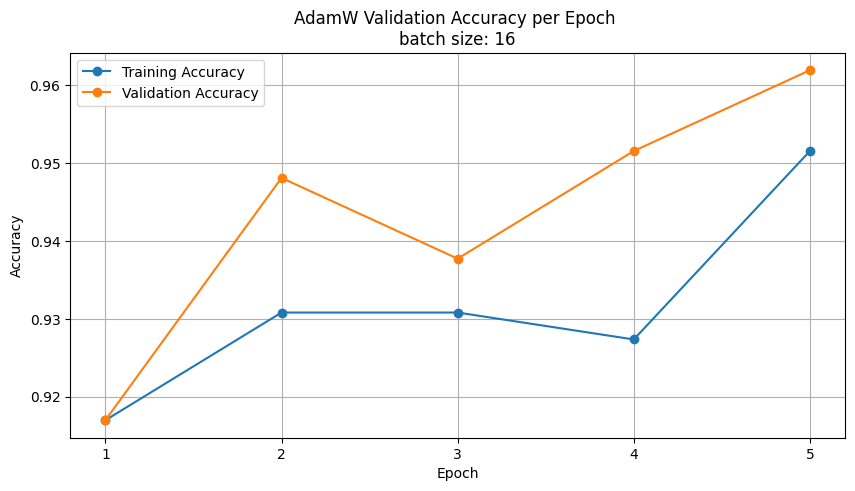

In [15]:
import matplotlib.pyplot as plt

# Initialize lists to store accuracy values for each epoch
train_accuracies = []
val_accuracies = []
# Calculate accuracy for each epoch
for epoch in range(epochs):
    # Training accuracy
    train_accuracy = accuracy_score(all_preds_train[epoch],all_labels_train[epoch])
    train_accuracies.append(train_accuracy)

    # Validation accuracy
    val_accuracy = accuracy_score(all_preds_val[epoch],all_labels_val[epoch])
    val_accuracies.append(val_accuracy)

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks([1,2,3,4,5])
# plt.title(f'{filename}\nTraining and Validation Accuracy per Epoch')
# plt.title(f'{filename} \nValidation Accuracy per Epoch')
plt.title(f'{hp["optimiser"]} Validation Accuracy per Epoch \nbatch size: '+str(hp['batch_size']))
plt.legend()
plt.grid(True)
plt.show()

0.95
0.9603403320982571
0.956796890572055
0.9604528207999006
0.9604528207999006


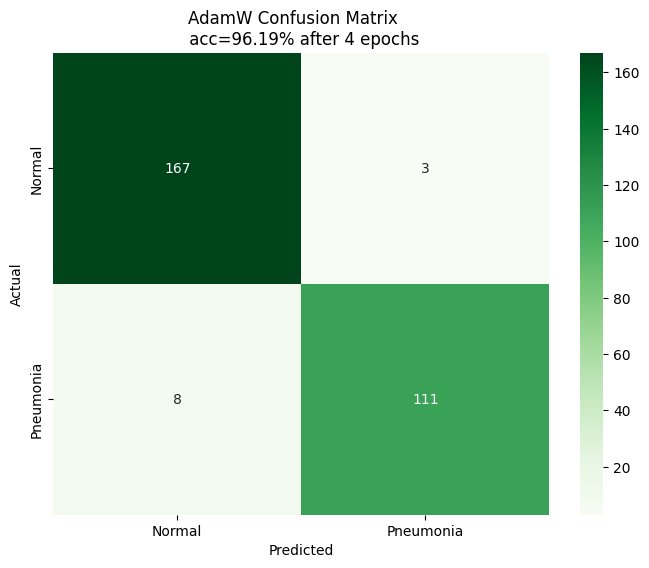

In [16]:
import seaborn as sns

best_epoch = 0
best_f1 = 0
for epoch in range(len(all_preds_val)):
    report = classification_report(all_labels_val[epoch], all_preds_val[epoch], output_dict=True)
    avg_f1 = (report['0']['f1-score'] + report['1']['f1-score']) / 2
    print(avg_f1)
    if avg_f1 > best_f1:
        best_f1 = avg_f1
        best_epoch = epoch
epoch = best_epoch
# print("The model achieved the highest accuracy on the validation set after training for",epoch+1,"epochs")
#print confusion matrix for the epoch with the highest validation accuracy
conf_matrix = confusion_matrix(all_labels_val[epoch], all_preds_val[epoch])
accuracy = accuracy_score(all_labels_val[epoch], all_preds_val[epoch])
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'{hp["optimiser"]} Confusion Matrix   \n acc={round(100*accuracy,2)}% after {epoch+1} epochs')
plt.show()

In [17]:
print(classification_report(all_labels_val[epoch], all_preds_val[epoch], digits=4))

              precision    recall  f1-score   support

           0     0.9543    0.9824    0.9681       170
           1     0.9737    0.9328    0.9528       119

    accuracy                         0.9619       289
   macro avg     0.9640    0.9576    0.9605       289
weighted avg     0.9623    0.9619    0.9618       289



In [18]:
# save accuracies and predictions to file for comparison with other models
with open(f'/content/drive/My Drive/Dissertation/reports/Models/scores/{filename}_{hp["optimiser"]}.pkl', 'wb') as f:
    pickle.dump({'train_accuracies': train_accuracies,
                 'train_preds':all_preds_train,
                 'train_labels':all_labels_train,
                 'val_accuracies': val_accuracies,
                 'val_preds':all_preds_val,
                 'val_labels':all_labels_val,
                 'parameters':hp,
                 'best_epoch':epoch+1}, f)

In [15]:
# filename = model_name_list[3].split('/')[1]
# print(filename)
with open(f'/content/drive/My Drive/Dissertation/reports/Models/scores/{filename}_batch16.pkl', 'rb') as f:
    data = pickle.load(f)
train_accuracies = data['train_accuracies']
all_preds_train = data['train_preds']
all_labels_train = data['train_labels']
val_accuracies =data['val_accuracies']
all_preds_val = data['val_preds']
all_labels_val = data['val_labels']
hp = data['parameters']
display(hp)
# data['best_epoch']

{'learning_rate': 5e-05,
 'weight_decay': 0.01,
 'gamma': 0.2,
 'batch_size': 16,
 'epochs': 5,
 'optimiser': 'AdamW'}

In [20]:
from sklearn.metrics import classification_report


#finding the epoch with the highest f1 score
best_epoch = 0
best_f1 = 0
for epoch in range(len(all_preds_val)):
    report = classification_report(all_labels_val[epoch], all_preds_val[epoch], output_dict=True)
    avg_f1 = (report['0']['f1-score'] + report['1']['f1-score']) / 2

    if avg_f1 > best_f1:
        best_f1 = avg_f1
        best_epoch = epoch

print(f"{filename} with {op} achieved the highest average F1-score:{best_f1:.4f} after {best_epoch+1} epochs")

Bio_ClinicalBERT with SGD achieved the highest average F1-score:0.6737 after 4 epochs


#Evaluate the model on the test data

In [46]:
#highest performing model so far
# model.load_state_dict(torch.load(f'/content/drive/MyDrive/Dissertation/reports/Models/Bio_ClinicalBERT_epoch_4_AdamW.pth',weights_only=True))
# model.load_state_dict(torch.load(f'/content/drive/MyDrive/Dissertation/reports/Models/Bio_ClinicalBERT_full.pth',weights_only=True))
model.load_state_dict(torch.load(f'/content/drive/MyDrive/Dissertation/reports/Models/Bio_ClinicalBERT_epoch_3.pth',weights_only=True)) #loading the highest performing model on the validation data

<All keys matched successfully>

In [47]:
model.eval()

test_preds = []
test_lbl = []
with torch.no_grad():
  for batch in tqdm(test_loader):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    _, preds = torch.max(logits, dim=1)
    test_preds.extend(preds.cpu().numpy())
    test_lbl.extend(labels.cpu().numpy())

  # Track metrics
  test_accuracy = accuracy_score(test_lbl, test_preds)

  # Print results
  print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

  torch.cuda.empty_cache()

  0%|          | 0/38 [00:00<?, ?it/s]<ipython-input-9-4fbd7a268d4e>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx]).long().clone().detach()
100%|██████████| 38/38 [00:03<00:00, 10.26it/s]

Test Accuracy: 91.90%


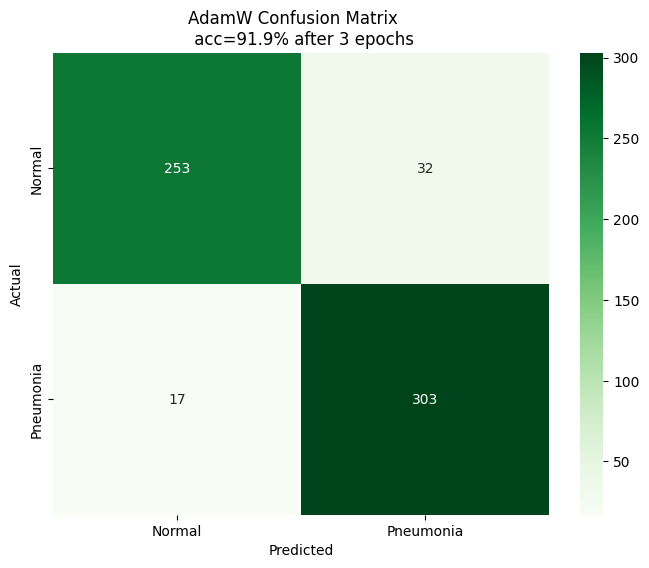

In [48]:

conf_matrix = confusion_matrix(test_lbl,test_preds)
accuracy = accuracy_score(test_lbl,test_preds)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'{hp["optimiser"]} Confusion Matrix   \n acc={round(100*accuracy,2)}% after 3 epochs')
plt.show()